# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence. 

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.

CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.


# Dataset

The dataset is composed by a snapshot of wikipedia. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary. In addition, we restricted to sequences with a length between 3 and 30 words.

(Ignore the error, if any) 

In [ ]:
!pip install datasets
!pip3 install apache-beam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.6-py3-none-any.whl (110 kB)
  Attempting uninstall: dill
    Found existing installation: dill 0.3.1.1
    Uninstalling dill-0.3.1.1:
      Successfully uninstalled dill-0.3.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.48.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dill-0.3.1.1-py3-none-any.whl
  Attempting uninstall: dill
    Found existing installation: dill 0.3.6
    Uninstalling dill-0.3.6:
      Successfully uninstalled dill-0.3.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of 

In [ ]:
from random import Random

# Instantiate the Random instance with random seed = 42 to ensure reproducibility
randomizer = Random(42)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, pad_sequences
import numpy as np 
import pickle
import gdown
import random

In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikipedia", "20220301.simple")

data = dataset['train'][:20000]['text']

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
#run this cell only the first time to create and save the tokenizer and the date
dump = True

tokenizer = Tokenizer(split=' ', filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n', num_words=10000, oov_token='<unk>')

corpus = []

# Split of each piece of text into sentences
for elem in data:
  corpus += elem.lower().replace("\n", "").split(".")[:]

print("corpus dim: ",len(corpus))

#add a start and an end token
corpus = ['<start> '+s+' <end>' for s in corpus]


# Tokenization	
tokenizer.fit_on_texts(corpus)
#print(tokenizer.word_index['<unk>'])

if dump:
    with open('tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

original_data = [sen for sen in tokenizer.texts_to_sequences(corpus) if (len(sen) <= 32 and len(sen)>4 and not(1 in sen))]

if dump:
    with open('original.pickle', 'wb') as handle:
        pickle.dump(original_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

print ("filtered sentences: ",len(original_data))

sos = tokenizer.word_index['<start>']
eos = tokenizer.word_index['<end>']
#print(eos)
#print(tokenizer.index_word[sos])

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

corpus dim:  510023
filtered sentences:  137301


We now create two additional datasets. 
* shuffled_data contains scrumbled sequences, and will be the input to the model. 
* target_data is the same as original data but offset by one timestep.
It is only useful if you plan to do some language modeling with a teacher forcing technique. You might decide to ignore it.


In [ ]:
shuffled_data = [random.sample(s[1:-1],len(s)-2) for s in original_data]
shuffled_data = [[sos]+s+[eos] for s in shuffled_data]
target_data = [s[1:] for s in original_data]

Let us look at some examples:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",original_data[i])
print("shuffled sentecen: ",shuffled_data[i])

original sentence:  [2, 4, 3437, 600, 3830, 50, 7879, 4929, 39, 282, 3]
shuffled sentecen:  [2, 4929, 3437, 39, 50, 600, 4, 7879, 282, 3830, 3]


Let us look at detokenized data:

In [ ]:
i = np.random.randint(len(original_data))
print("original sentence: ",tokenizer.sequences_to_texts([original_data[i]])[0])
print("shuffled sentence: ",tokenizer.sequences_to_texts([shuffled_data[i]])[0])

original sentence:  <start> they may be explorers who like to go to far away places where no one has ever been before <end>
shuffled sentence:  <start> away no to before has may they ever been places explorers like far where be go who to one <end>


You goal is to reconstruct the original sentence out of the shuffled one.

# Additional material

Here we provide a few additional functions that could be useful to you.

As usual, you are supposed to divide your data in training and test set. Reserve at least 30% of data for testing.

You are likely to need a validation set too.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, c_train, c_test, y_train, y_test = train_test_split(original_data, shuffled_data, target_data, test_size = 0.3, random_state = 42)


Depending from the model you plan to build, you might require padding the input sequence

In [ ]:
max_sequence_len = max([len(x) for x in original_data])

x_train = pad_sequences(x_train, maxlen=max_sequence_len, padding='post')
x_test = pad_sequences(x_test, maxlen=max_sequence_len, padding='post')
c_train = pad_sequences(c_train, maxlen=max_sequence_len, padding='post')
c_test = pad_sequences(c_test, maxlen=max_sequence_len, padding='post')
y_train = pad_sequences(y_train, maxlen=max_sequence_len, padding='post')
y_test = pad_sequences(y_test, maxlen=max_sequence_len, padding='post')

In [ ]:
print("x_train size:", len(x_train))
assert(len(x_train)==len(c_train)==len(y_train))

x_train size: 96110


Let us finally have a look at the distribution of data w.r.t. their lenght.

(array([ 3897.,  5516.,  6180.,  7633., 10474., 11260., 11167., 10501.,
         9768.,  8942.,  7828.,  7010.,  6126.,  5236.,  4551.,  3922.,
         3260.,  2695.,  2306.,  1922.,  1611.,  1299.,  1126.,   827.,
          773.,   586.,   885.]),
 array([ 3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15.,
        16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
        29., 30.]),
 <BarContainer object of 27 artists>)

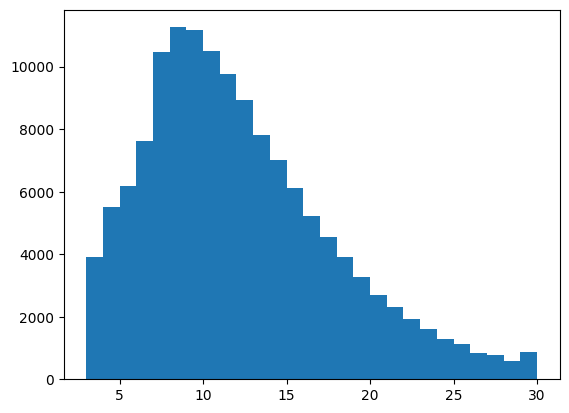

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x)-2 for x in original_data],27)

This is a sequence-to-sequence (seq2seq) model with attention mechanism built using the Keras API of TensorFlow.

The model is split into two main parts: the encoder and the decoder. Each of these parts is composed of LSTM (Long Short-Term Memory) layers. The encoder reads the input sequences and returns its own internal state (hidden state and cell state). This state is used as the initial state for the decoder, which generates the output sequences.

The encoder is composed of three LSTM layers, which help to capture more complex patterns in the input sequences. The final hidden and cell states of the encoder are passed to the decoder.

The decoder is a single LSTM layer followed by an Attention layer and a Dense layer. The Attention layer enables the decoder to focus on different parts of the encoder's outputs for every step of the decoder's own outputs. It enhances the performance of the seq2seq model especially when handling long sequences.

The model uses RMSprop optimizer with a learning rate of 0.001, and is trained to minimize the 'sparse_categorical_crossentropy' loss, which is suitable for multi-class classification tasks.

The embedding layer is used to convert input sequences into dense vectors of fixed size which are more suitable for a neural network. The number of distinct words in the vocabulary is defined by vocab_size.

The summary of the model would provide a layer-by-layer description of the architecture, the output shapes and the number of parameters.

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Attention

# Model hyperparameters
vocab_size = 10000 + 4
max_sequence_len = max([len(x) for x in original_data])
embed_dim = 100
lstm_units = 256

# Define the input layer (encoder)
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(input_dim=vocab_size, output_dim=embed_dim)(encoder_inputs)

# LSTM 1 
encoder_lstm1 = LSTM(lstm_units,return_sequences=True,return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2 = LSTM(lstm_units,return_sequences=True,return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3=LSTM(lstm_units, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, which will use encoder_states as initial state.
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(input_dim=vocab_size, output_dim=embed_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Attention layer
attn_layer = Attention(name='attention_layer')
attn_out = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# Dense layer
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 100)    1000400     ['input_3[0][0]']                
                                                                                                  
 lstm_4 (LSTM)                  [(None, None, 256),  365568      ['embedding_2[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

In the provided code, I've set up a path for saving my model weights to a file named "model_weights_best.hdf5". The intention is to keep a record of the best performing model during the training process.

I've then initialized a ModelCheckpoint instance from Keras callbacks, which I've configured to monitor the validation loss (or val_loss). I've chosen to monitor this metric because the goal of the training process is to minimize it. If in any epoch, the model achieves a lower validation loss than the previous best, the weights of this model are saved, replacing the previous file. This is controlled by the parameters save_best_only=True and mode='min'.

Finally, I've started the training process of my model by calling the fit method. I've passed the training data, specified the batch size to be 64, and set the number of epochs to 30. I've also reserved 20% of my training data for validation, to monitor the model's performance on unseen data during training. To this fit call, I've passed the ModelCheckpoint instance as a callback, so it's invoked at the end of each epoch.


During the final epochs of the model's training process, the model continued to improve. In the 29th epoch, the model achieved a training loss of 0.0277 and an accuracy of 0.9993. Upon evaluation, the validation loss was 0.0994 and the validation accuracy was 0.9864. This was an improvement from the previous best validation loss, and therefore, the model weights at this stage were saved to "model_weights_best.hdf5".

The model further improved during the 30th and final epoch, achieving a training loss of 0.0251 and an accuracy of 0.9995. The validation loss and accuracy were 0.0950 and 0.9869 respectively, marking an improvement over all previous epochs. Therefore, the weights of the model at this stage were saved, replacing the previously stored weights.

In conclusion, the model achieved its best performance in the final epoch, with a training accuracy of 0.9995, validation accuracy of 0.9869, and a minimum validation loss of 0.0950. The weights at this point are stored in "model_weights_best.hdf5".

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Specify the path to save the model
filepath = "model_weights_best.hdf5"

# Initialize the ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Model fitting with early stopping
history = model.fit([c_train, x_train], y_train,
          batch_size=64,
          epochs=30,
          validation_split=0.2,
          callbacks=[checkpoint])

Epoch 1/30
1202/1202 [==============================] - ETA: 0s - loss: 2.5565 - accuracy: 0.6585
Epoch 1: val_loss improved from inf to 2.34828, saving model to model_weights_best.hdf5
1202/1202 [==============================] - 122s 89ms/step - loss: 2.5565 - accuracy: 0.6585 - val_loss: 2.3483 - val_accuracy: 0.6754
Epoch 2/30
1202/1202 [==============================] - ETA: 0s - loss: 2.1835 - accuracy: 0.6946
Epoch 2: val_loss improved from 2.34828 to 2.02923, saving model to model_weights_best.hdf5
1202/1202 [==============================] - 83s 69ms/step - loss: 2.1835 - accuracy: 0.6946 - val_loss: 2.0292 - val_accuracy: 0.7197
Epoch 3/30
1202/1202 [==============================] - ETA: 0s - loss: 1.7245 - accuracy: 0.7623
Epoch 3: val_loss improved from 2.02923 to 1.48045, saving model to model_weights_best.hdf5
1202/1202 [==============================] - 82s 68ms/step - loss: 1.7245 - accuracy: 0.7623 - val_loss: 1.4804 - val_accuracy: 0.7953
Epoch 4/30
1202/1202 [======

In [ ]:
model.save('LSTM_AttentionV2.h5')

After training, when the model was evaluated on the test set, it achieved an average score of 0.6451.

In [ ]:
from difflib import SequenceMatcher
import numpy as np

def score(s, p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  return match.size / len(s)

# Define batch size for prediction
batch_size = 500

# Placeholder for predicted sentences
predicted_sentences = []

# Predict in batches
for i in range(0, len(x_test), batch_size):
    # Create decoder input data for current batch
    decoder_input_data_test = np.zeros((len(x_test[i:i+batch_size]), max_sequence_len))
    
    # Generate predictions for current batch
    predictions = model.predict([x_test[i:i+batch_size], decoder_input_data_test])
    
    # Convert predictions to token sequences
    predicted_sequences = np.argmax(predictions, axis=-1)
    
    # Convert token sequences back to words
    predicted_sentences_batch = [tokenizer.sequences_to_texts([pred])[0] for pred in predicted_sequences]
    
    # Add current batch's predicted sentences to the main list
    predicted_sentences.extend(predicted_sentences_batch)

# After all predictions have been generated, remove <start> and <end> tokens
predicted_sentences = [s.replace('<start> ', '').replace(' <end>', '') for s in predicted_sentences]

# Now convert y_test sequences back to words
true_sentences = [tokenizer.sequences_to_texts([seq])[0] for seq in y_test]
true_sentences = [s.replace('<start> ', '').replace(' <end>', '') for s in true_sentences]

# Compute scores for each predicted sentence
scores = [score(true, predicted) for true, predicted in zip(true_sentences, predicted_sentences)]

# Calculate the average score
average_score = np.mean(scores)

print("The average score on the test set is", average_score)


6/6 [==============================] - 0s 10ms/step
The average score on the test set is 0.6450932857471109


# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/|s|

If the match is exact, the score is 1. 

When computing the score, you should NON consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [ ]:
from difflib import SequenceMatcher

def score(s,p):
  match = SequenceMatcher(None, s, p).find_longest_match()
  #print(match.size)
  return (match.size/len(p))

Let's do an example.

In [ ]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented. 
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training. 
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Good work!